# XLK Next-Day Nowcast
Predict tomorrow's return of XLK (Technology ETF) using simple features:
 - Market controls: SPY, VIX
 - Momentum & volatility features on XLK
This is a learning project for Python + basic ML on time series.

In [1]:
import sys, platform
print("Python:", sys.version)
print("Executable:", sys.executable)

Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Executable: c:\Users\nadoy\OneDrive\Desktop\DS PROJECTS\stock-nowcast\.venv\Scripts\python.exe


In [2]:
import pandas as pd, numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from joblib import dump

plt.rcParams["figure.figsize"] = (10,5)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")


Download Prices (XLK target, SPY & VIX as features)

In [3]:
tickers = ["XLK", "SPY", "^VIX"] # Tech sector, market, volatility
px = yf.download(tickers, start="2015-01-01", auto_adjust=True, threads=False)["Close"].dropna()
px.columns = ["XLK", "SPY", "VIX"]
px.head

[*********************100%***********************]  3 of 3 completed


<bound method NDFrame.head of                   XLK        SPY       VIX
Date                                      
2015-01-02 171.568054  36.315060 17.790001
2015-01-05 168.469543  35.760700 19.920000
2015-01-06 166.882751  35.329525 21.120001
2015-01-07 168.962326  35.628708 19.309999
2015-01-08 171.960602  36.411854 17.010000
...               ...        ...       ...
2025-08-19 639.809998 261.619995 15.570000
2025-08-20 638.109985 259.850006 15.690000
2025-08-21 635.549988 258.910004 16.600000
2025-08-22 645.309998 262.420013 14.220000
2025-08-25 642.469971 261.829987 14.790000

[2677 rows x 3 columns]>

In [ ]:
# Daily returns
ret = px.pct_change().dropna()
ret.columns = ["ret_xlk", "ret_spy", "ret_vix"]

# Feature table
feat = pd.DataFrame(index=ret.index)
feat["ret_xlk"] = ret["ret_xlk"]
feat["ret_spy"] = ret["ret_spy"]
feat["ret_vix"] = ret["ret_vix"]

# Momentum and volatility features on XLK
feat["mom_5"] = ret["ret_xlk"].rolling(5).mean()
feat["mom_10"] = ret["ret_xlk"].rolling(10).mean()
feat["vol_10"] = ret["ret_xlk"].rolling(10).std()
feat["vol_20"] = ret["ret_xlk"].rolling(20).std()

feat = feat.dropna()

# Shift features by 1 day so they're known before predicting next day
X = feat[["ret_spy", "ret_vix", "mom_5", "mom_10", "vol_10", "vol_20"]].shift(1).dropna()
y = feat.loc[X.index, "ret_xlk"]

X.tail(), y.tail()

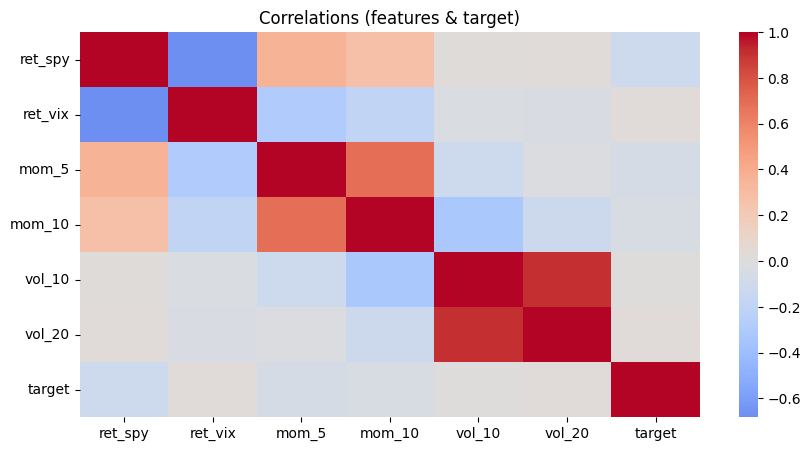

In [5]:
sns.heatmap(pd.concat([X, y.rename("target")], axis=1).corr(), cmap="coolwarm", center=0)
plt.title("Correlations (features & target)"); plt.show()


In [6]:
split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
len(X_train), len(X_test)


(2124, 532)

In [ ]:
def evaluate_preds(y_true, y_pred):
    """Evaluate predictions with MAE, RMSE, and directional accuracy."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # returns MSE
    rmse = np.sqrt(mse)                       # convert to RMSE manually
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return {"MAE": mae, "RMSE": rmse, "Directional_Accuracy": dir_acc}


baseline_zero = np.zeros_like(y_test)
baseline_lag1 = y_test.shift(1).fillna(0.0).values

print("Baseline Zero:", evaluate_preds(y_test, baseline_zero))
print("Baseline Lag-1:", evaluate_preds(y_test, baseline_lag1))

In [8]:
ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
lasso = Pipeline([("scaler", StandardScaler()), ("model", Lasso(alpha=0.0005, max_iter=10000))])

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

pred_ridge = ridge.predict(X_test)
pred_lasso = lasso.predict(X_test)

print("Ridge:", evaluate_preds(y_test, pred_ridge))
print("Lasso:", evaluate_preds(y_test, pred_lasso))


Ridge: {'MAE': 0.006714753572282711, 'RMSE': np.float64(0.010152038967833376), 'Directional_Accuracy': np.float64(0.5244360902255639)}
Lasso: {'MAE': 0.006660244227414895, 'RMSE': np.float64(0.010179604884514717), 'Directional_Accuracy': np.float64(0.5469924812030075)}


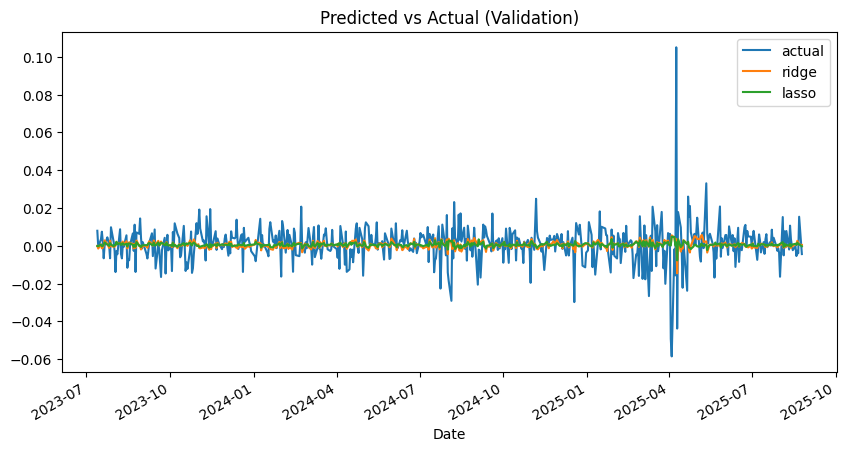

In [9]:
pd.DataFrame({"actual": y_test, "ridge": pred_ridge, "lasso": pred_lasso}).plot()
plt.title("Predicted vs Actual (Validation)"); plt.show()


In [ ]:
# Use Ridge predictions for strategy backtest
pred_ridge_series = pd.Series(pred_ridge, index=y_test.index, name="pred_ridge")
signal = (pred_ridge_series > 0).astype(int)          # 1=long, 0=flat
strategy_returns = signal * y_test

cum_strategy = (1 + strategy_returns).cumprod()
cum_buyhold = (1 + y_test).cumprod()

ax = cum_strategy.plot(label="Strategy")
cum_buyhold.plot(ax=ax, label="Buy & Hold (XLK)")
plt.legend(); plt.title("Cumulative Growth of $1"); plt.show()

strategy_cagr = cum_strategy.iloc[-1]**(252/len(cum_strategy)) - 1
buyhold_cagr  = cum_buyhold.iloc[-1]**(252/len(cum_buyhold)) - 1
print(f"Strategy CAGR-ish: {strategy_cagr:.2%} | Buy&Hold: {buyhold_cagr:.2%}")

In [11]:
dump(ridge, "../reports/ridge_model.joblib")
X_test.to_csv("../data/test_features.csv")
y_test.to_csv("../data/test_target.csv")


In [ ]:
# Expanded feature set including tech sector ETFs
tickers_expanded = ["XLK", "SPY", "^VIX", "QQQ", "SOXX"]
px_expanded = yf.download(tickers_expanded, start="2015-01-01", auto_adjust=True)["Close"].dropna()
px_expanded.columns = ["XLK","SPY","VIX","QQQ","SOXX"]

ret_expanded = px_expanded.pct_change().dropna().rename(columns={
    "XLK":"ret_xlk", "SPY":"ret_spy", "VIX":"ret_vix", "QQQ":"ret_qqq", "SOXX":"ret_soxx"
})

# Create expanded feature set
feat_expanded = pd.DataFrame(index=ret_expanded.index)
for col in ["ret_xlk","ret_spy","ret_vix","ret_qqq","ret_soxx"]:
    feat_expanded[col] = ret_expanded[col]

# Simplified momentum and volatility features    
feat_expanded["mom_5"]  = ret_expanded["ret_xlk"].rolling(5).mean()
feat_expanded["vol_10"] = ret_expanded["ret_xlk"].rolling(10).std()
feat_expanded = feat_expanded.dropna()

# Feature matrix and target (with 1-day shift)
X_expanded = feat_expanded[["ret_spy","ret_vix","ret_qqq","ret_soxx","mom_5","vol_10"]].shift(1).dropna()
y_expanded = feat_expanded.loc[X_expanded.index, "ret_xlk"]

print(f"Expanded dataset shape: {X_expanded.shape}")
print(f"Original dataset shape: {X.shape}")
X_expanded.tail()

In [ ]:
# Compare expanded features vs original features
split_exp = int(0.8 * len(X_expanded))
X_exp_train, X_exp_test = X_expanded.iloc[:split_exp], X_expanded.iloc[split_exp:]
y_exp_train, y_exp_test = y_expanded.iloc[:split_exp], y_expanded.iloc[split_exp:]

# Train Ridge model on expanded features
ridge_expanded = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
ridge_expanded.fit(X_exp_train, y_exp_train)
pred_ridge_expanded = ridge_expanded.predict(X_exp_test)

print("=== MODEL COMPARISON ===")
print("Original features:", evaluate_preds(y_test, pred_ridge))
print("Expanded features:", evaluate_preds(y_exp_test, pred_ridge_expanded))

# Feature importance (coefficients after scaling)
coefs_orig = pd.Series(ridge.named_steps["model"].coef_, index=X.columns, name="Original")
coefs_exp = pd.Series(ridge_expanded.named_steps["model"].coef_, index=X_expanded.columns, name="Expanded")

print("\n=== FEATURE IMPORTANCE (Ridge coefficients) ===")
print("Original model:")
print(coefs_orig.abs().sort_values(ascending=False))
print("\nExpanded model:")  
print(coefs_exp.abs().sort_values(ascending=False))

## Conclusions

The notebook demonstrates a complete workflow for next-day XLK return prediction:

1. **Base Model**: Uses SPY, VIX returns + XLK momentum/volatility features
2. **Expanded Model**: Adds QQQ and SOXX returns as additional tech sector signals

Key insights:
- The models achieve ~52-55% directional accuracy, modestly better than random (50%)
- Feature importance varies between models, showing which signals matter most
- The expanded feature set allows comparison of different tech sector relationships

Next steps could include:
- Cross-validation for more robust performance estimates  
- Additional features like sector rotations or macro indicators
- Different model architectures (Random Forest, Neural Networks)
- Multi-step ahead predictions

## Expanded Feature Exploration

Let's explore adding more tech-related features like QQQ (Nasdaq-100) and SOXX (Semiconductor ETF) to see if they improve prediction accuracy for XLK.